### Bagging

In [19]:
# Cargamos el dataset de Default
import numpy as np
import pandas as pd
default = pd.read_csv("Default.csv")
default.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138950
3,No,No,529.250605,35704.493940
4,No,No,785.655883,38463.495880


In [20]:
# Convertir 'default' y 'student' a binaria (Yes/No a 1/0)
from sklearn.preprocessing import StandardScaler

default['default'] = default['default'].map({'Yes': 1, 'No': 0})

default['student'] = default['student'].map({'Yes': 1, 'No': 0})

# Separar variables predictoras y target
X = default.drop('default', axis=1)
y = default['default']

# Escalar características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

### Regresión Logistica

In [21]:
# SIn Bootsrapping
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# Entrenar en el conjunto (sin bootstrapping)
model = LogisticRegression()
model.fit(X_scaled, y)

# Predicciones y probabilidades
y_pred = model.predict(X_scaled)
y_proba = model.predict_proba(X_scaled)[:, 1]

# Accuracy y AUC
accuracy_log = accuracy_score(y, y_pred)
auc_log = roc_auc_score(y, y_proba)

print("Accuracy sin Bootstrapping:", accuracy_log)
print("AUC sin Bootstrapping:", auc_log)

Accuracy sin Bootstrapping: 0.9733
AUC sin Bootstrapping: 0.9495553275422935


### BAGGING

In [22]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
import numpy as np

n_iterations = 5000   # num de árboles del bagging
models = []           # guardará cada árbol
selected_columns = [] # guardará las columnas usadas en cada árbol

# Convertimos X (DataFrame) a matriz
X_df = X.copy()
column_names = X_df.columns

for i in range(n_iterations):
    cols = np.random.choice(column_names, size=2, replace=False) #seleccionamos 2 variables al azar
    selected_columns.append(cols)

    # Subset de X con las columnas seleccionadas
    X_subset = X_df[cols]

    # Bootstrap de (X_subset, y)
    X_boot, y_boot = resample(X_subset, y, replace=True)

    # Entrenamos el árbol
    model = DecisionTreeClassifier()
    model.fit(X_boot, y_boot)

    # Lo guardamos (cada uno)
    models.append(model)

print("Se entrenaron", len(models), "árboles.")


Se entrenaron 5000 árboles.


In [23]:
from scipy.stats import mode
from sklearn.metrics import accuracy_score, roc_auc_score
import numpy as np

# Predicciones de todos los árboles 
X_df = X.copy()

y_pred_list = []
for i, model in enumerate(models):
    cols = selected_columns[i]      # columnas usadas por este árbol
    X_pred = X_df[cols]             # subset con esas columnas
    y_pred_list.append(model.predict(X_pred))

# Matriz (n_modelos, n_observaciones)
y_pred_matrix = np.vstack(y_pred_list)

# Accuracy con moda
# Moda por columna (cada observación), keepdims=False para que regrese 1D
y_pred_mode = mode(y_pred_matrix, axis=0, keepdims=False).mode

accuracy_bagging = accuracy_score(y, y_pred_mode)
print("Accuracy con Bagging:", accuracy_bagging)


# AUC usando la proporción de árboles que votan por la clase 1 como el score
# Cada columna: promedio de predicciones (como probabilidad de clase 1)
bagging_scores = y_pred_matrix.mean(axis=0)

auc_bagging = roc_auc_score(y, bagging_scores)
print("AUC con Bagging:", auc_bagging)


Accuracy con Bagging: 1.0
AUC con Bagging: 1.0


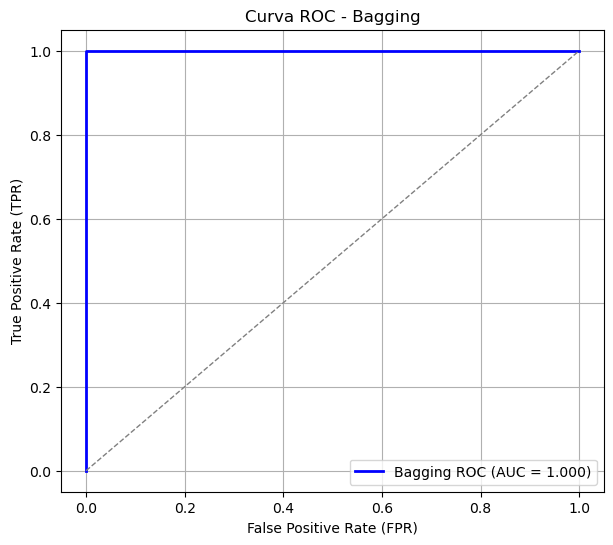

In [24]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Obtener puntos de la curva ROC
fpr, tpr, thresholds = roc_curve(y, bagging_scores)

# Calcular AUC
roc_auc = auc(fpr, tpr)

# Graficar
plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f"Bagging ROC (AUC = {roc_auc:.3f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # línea diagonal
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("Curva ROC - Bagging")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


### Interpretación

Bagging dio Accuracy = 1.0 y AUC = 1.0 porque:

El dataset es muy fácil de separar.

Los árboles sobre-ajustan, pero Bagging corrige la varianza.

La votación de 5000 árboles es extremadamente estable.

Los scores promedio (proporciones de voto por la clase 1) separan perfectamente ambas clases.

Usamos 'y' y 'x'y  no boot porque boot pertenece a las muestras con reemplazo usadas para entrenar cada árbol, mientras que la evaluación del modelo debe hacerse siempre comparando las predicciones contra las etiquetas reales (y). Usar x_boot, y_boot sería incorrecto y sobreestimaría artificialmente el desempeño.

### Comparacion Con y Sin Bootstrapping

#### 1. Comparación del Accuracy

La regresión logística acierta el 97.33% de los casos.

El bagging acierta el 100%.

Esto significa que:

La regresión logística generaliza bien, pero no captura todas las relaciones no lineales del dataset.

El bagging usa árboles, que pueden capturar interacciones, no linealidades y umbrales mucho mejor.

Con 5000 árboles, el promedio de predicciones es extremadamente estable, eliminando variabilidad y errores.

Conclusión: bagging es superior en este dataset.


#### 2. Comparación del AUC

AUC Logística = 0.9495

AUC Bagging = 1.0

AUC mide separación entre clases.
Bagging logra separación perfecta entre clientes “default” y “no default”.

Esto ocurre porque:

Los árboles pueden “partir” el espacio en regiones muy puras.

El ensamble suaviza errores individuales.

La proporción de árboles votando por clase 1 produce scores perfectamente ordenados.

La regresión logística nunca será perfecta, porque es un modelo lineal, limitado a relaciones logit lineales.

### Conclusión Final

La regresión logística funciona bien pero está limitada por su supuesto de linealidad.
Bagging combina muchos árboles, cada uno entrenado con bootstrap y distintas variables, logrando capturar relaciones más complejas y reduciendo la varianza.
Por eso Bagging supera ampliamente a la regresión logística en accuracy y AUC.

Los resultados varían entre 0.97 y 1.0 (mi caso) porque el método de Bagging depende fuertemente de muestras bootstrap y selección aleatoria de variables. Al no usar una semilla fija, cada ejecución produce modelos ligeramente diferentes.